In [74]:
from sklearn.model_selection import train_test_split
import processing
import model
import numpy as np
import random
import matplotlib.pyplot as plt

In [75]:
# Import data
data = np.genfromtxt("data.csv", delimiter=',', dtype=str)[1:]

# Tokenize data
compounds_str = data[:,1]
compounds_tok = []
for comp in compounds_str:
    compounds_tok.append(processing.comp_tokenizer(comp))

steps_str = data[:,2]
reagents_str = data[:,3]
decoder_input_synth = []
decoder_target_synth = []
for i,synth in enumerate(zip(steps_str,reagents_str)):
    input_steps, target_steps = processing.synth_tokenizer(synth[0],synth[1])
    decoder_input_synth.append(input_steps)
    decoder_target_synth.append(target_steps)

# Split train and test data
comp_train, comp_test, inp_train, inp_test, tar_train, tar_test = train_test_split(compounds_tok, decoder_input_synth, decoder_target_synth, test_size=0.2, random_state=42)

In [76]:
# Define hyperparameters
input_vocab_size = 8
target_vocab_size = 18
input_sequence_length = 6
output_sequence_length = 9
encoder_dim = 4
decoder_dim = 8
num_heads = 8
qkv_dim = 3
num_layers = 6
dff = 64
dropout_rate = 0.1

In [77]:
# tf.random.set_seed(42)                                #Set seed for reproducability

transformer = model.Transformer(
    num_layers=num_layers,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout_rate=dropout_rate)

In [78]:
output = transformer((model.tf.convert_to_tensor(compounds_tok, dtype=model.tf.float32), model.tf.convert_to_tensor(decoder_input_synth, dtype=model.tf.float32)))
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores

transformer.summary()

Model: "transformer_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_6 (Encoder)         multiple                  7280      
                                                                 
 decoder_6 (Decoder)         multiple                  30912     
                                                                 
 dense_174 (Dense)           multiple                  162       
                                                                 
Total params: 38,354
Trainable params: 38,354
Non-trainable params: 0
_________________________________________________________________


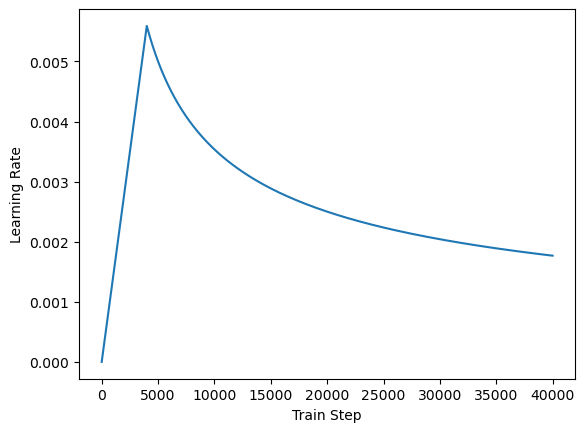

In [79]:
learning_rate = model.CustomSchedule(8)
plt.plot(learning_rate(model.tf.range(40_000, dtype=model.tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

optimizer = model.tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [80]:
transformer.compile(
    loss=model.masked_loss,
    optimizer=optimizer,
    metrics=[model.tf.keras.metrics.SparseCategoricalAccuracy()])
# .compile(optimizer=optimizer, loss=loss_function, metrics=[SparseCategoricalAccuracy()])

In [81]:
# Initialize variables to store losses and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

epochs = 100
batch_size = 32
print_every = 20 #Epochs

for epoch in range(epochs):
#     batch_size = random.randint(4,32)

    # Perform one epoch of training
    history = transformer.fit([np.array(comp_train), np.array(inp_train)], np.array(tar_train), batch_size=batch_size, epochs=1, verbose=0)

    # Evaluate the model on the training data
    train_loss, train_accuracy = transformer.evaluate([np.array(comp_train), np.array(inp_train)], np.array(tar_train), verbose=0)

    # Evaluate the model on the test data
    test_loss, test_accuracy = transformer.evaluate([np.array(comp_test), np.array(inp_test)], np.array(tar_test), verbose=0)

    # Append the results to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print the progress if needed
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# After the loop, you can access the lists train_losses, train_accuracies, test_losses, and test_accuracies to analyze the results

Epoch 20/100: Train Loss: 2.3041, Train Accuracy: 0.2113, Test Loss: 2.2807, Test Accuracy: 0.2131
Epoch 40/100: Train Loss: 1.9880, Train Accuracy: 0.2801, Test Loss: 1.9633, Test Accuracy: 0.2933
Epoch 60/100: Train Loss: 1.7127, Train Accuracy: 0.3165, Test Loss: 1.7169, Test Accuracy: 0.3224
Epoch 80/100: Train Loss: 1.4367, Train Accuracy: 0.3429, Test Loss: 1.4508, Test Accuracy: 0.3497
Epoch 100/100: Train Loss: 1.2509, Train Accuracy: 0.3638, Test Loss: 1.2700, Test Accuracy: 0.3570


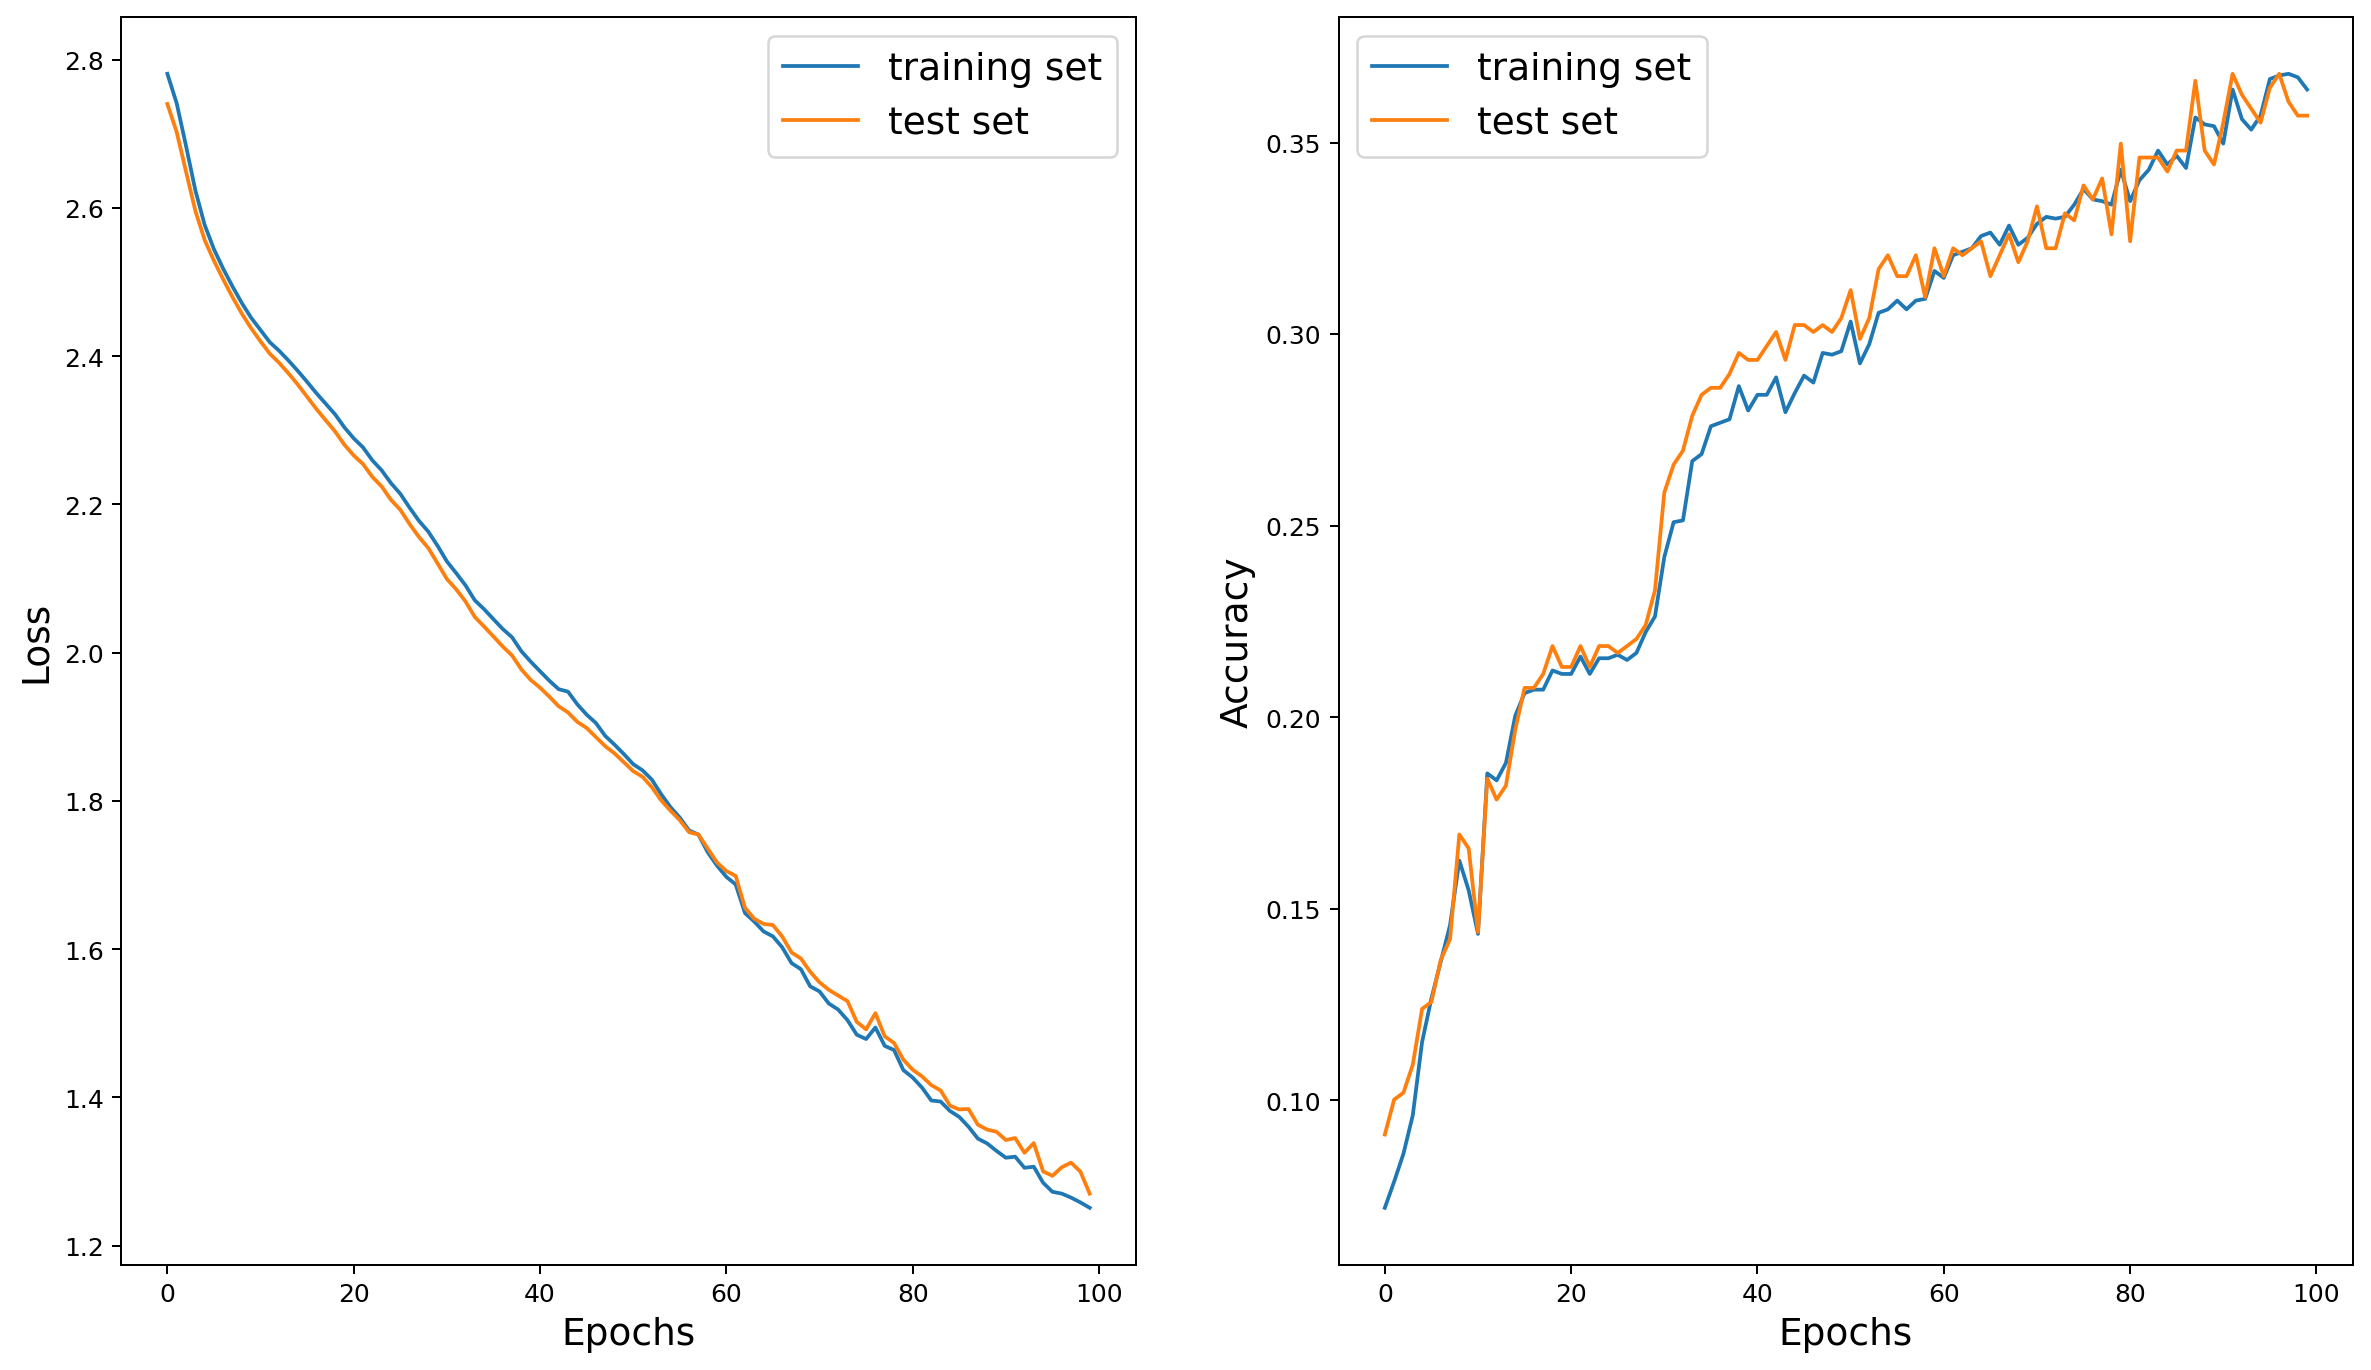

In [82]:
fig, axes = plt.subplots(1,2,figsize=(16,9), dpi = 180)
axes[0].plot(range(len(train_losses)), train_losses, label="training set")
axes[0].plot(range(len(test_losses)), test_losses, label="test set")
axes[1].plot(range(len(train_accuracies)), train_accuracies, label="training set")
axes[1].plot(range(len(test_accuracies)), test_accuracies, label="test set")
axes[0].set_xlabel("Epochs", fontsize=15)
axes[1].set_xlabel("Epochs", fontsize=15)
axes[0].set_ylabel("Loss", fontsize=15)
axes[1].set_ylabel("Accuracy", fontsize=15)
axes[0].legend(loc="upper right", fontsize=15)
axes[1].legend(loc="upper left", fontsize=15)
plt.show()
# plt.savefig('/kaggle/graphs/training.png')

In [121]:
# Define the input sequence (tokenized and preprocessed)
input_string = processing.create_compound(3)
input_sequence = processing.comp_tokenizer(input_string)  # Example input sequence as integer tokens
max_length=9


encoder_input = np.array([input_sequence])

start = [1]
end = [2]

# `tf.TensorArray` is required here (instead of a Python list), so that the
# dynamic-loop can be traced by `tf.function`.
output_array = model.tf.TensorArray(dtype=model.tf.int64, size=0, dynamic_size=True)
output_array = output_array.write(0, start)

for i in range(max_length):
    output = model.tf.transpose(output_array.stack())
    predictions = transformer([encoder_input, output], training=False)

    # Select the last token from the `seq_len` dimension.
    predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

    predicted_id = model.tf.argmax(predictions, axis=-1)

    # Concatenate the `predicted_id` to the output which is given to the
    # decoder as its input.
    output_array = output_array.write(i+1, predicted_id[0])

    if predicted_id == end:
        break

output = model.tf.transpose(output_array.stack())

print(output)

tokenization_step = {0: "",1: "<start>",2: "<end>",3: "SE",4: "RE",5: "SE",6: "RE",7: "SN",8: "SA",9: "SN",10: "SA",11: "SA",12: "OX",13: "SE",14: "RE",15: "PO",16: "UP",17: "OX"}
tokenization_reac = {0: "",1: "<start>",2: "<end>",3: "NO2",4: "NH2",5: "Ha",6: "C",7: "F",8: "F",9: "OH",10: "Ha",11: "OH",12: "NO2",13: "CO",14: "B",15: "",16: "",17: "B"}
tokenization = {"": 0, "<start>": 1, "<end>": 2, "SENO2": 3, "RENH2": 4, "SEHa": 5, "REC": 6, "SNF": 7, "SAF": 8, "SNOH": 9, "SAHa": 10, "SAOH": 11, "OXNO2": 12, "SECO": 13, "REB": 14, "PO": 15, "UP": 16, "OXB": 17}
rev_tok = {v: k for k, v in tokenization.items()}
generated_steps, generated_reactants = "",""
synthesis = []
for i in np.array(output[0]):
    generated_steps = generated_steps + tokenization_step[i] + "."
    generated_reactants = generated_reactants + tokenization_reac[i] + "."
    synthesis.append(rev_tok[i])
generated_steps = generated_steps[8:]
generated_reactants = generated_reactants[8:-1]
print("To synthesise " + input_string + " you need to introduce the groups " + generated_reactants + " with the reactions " + generated_steps)

transformer([encoder_input, output[:,:-1]], training=False)
compound = input_string.split(".")

cross_attention_weights = transformer.decoder.last_attn_scores
cross_attention_heads = model.tf.squeeze(cross_attention_weights, 0)

self_attention_enc_weights = transformer.encoder.last_self_attn_scores
self_attention_enc_heads = model.tf.squeeze(self_attention_enc_weights, 0)

self_attention_dec_weights = transformer.decoder.last_self_attn_scores
self_attention_dec_heads = model.tf.squeeze(self_attention_dec_weights, 0)

tf.Tensor([[ 1  3  4  3 11  4  8  2]], shape=(1, 8), dtype=int64)
To synthesise NH2.CO.F.H.H.H you need to introduce the groups NO2.NH2.NO2.OH.NH2.F.<end> with the reactions SE.RE.SE.SA.RE.SA.<end>.


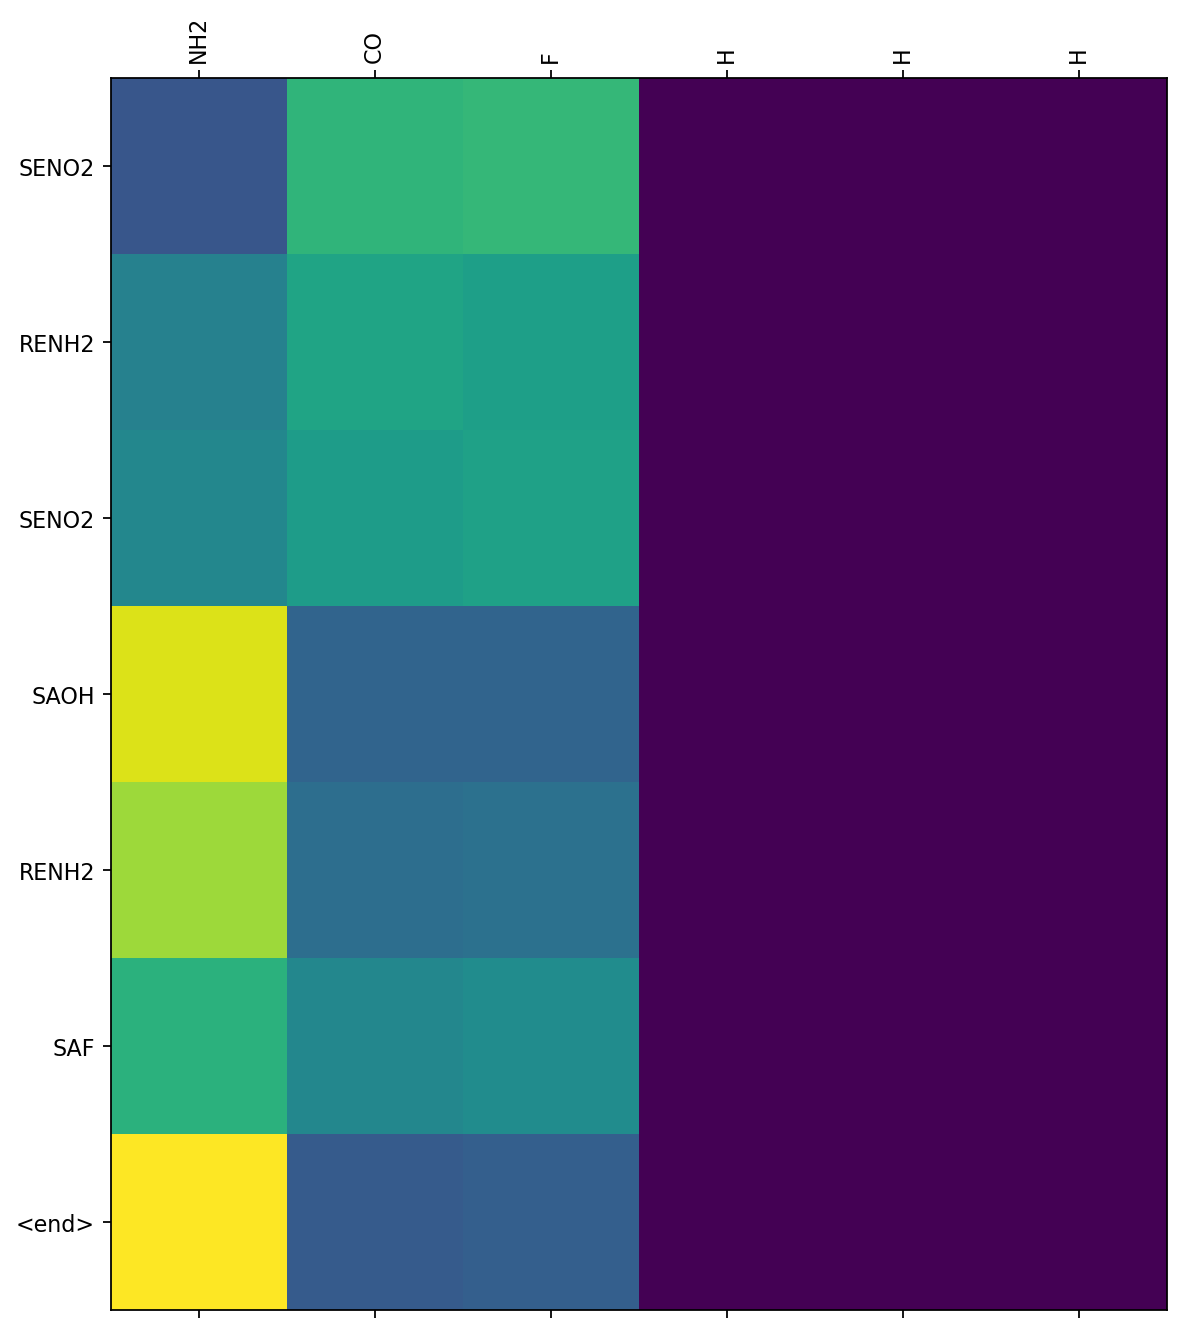

In [122]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention = cross_attention_heads[head]
attention.shape
processing.plot_attention_head(attention, compound, synthesis)

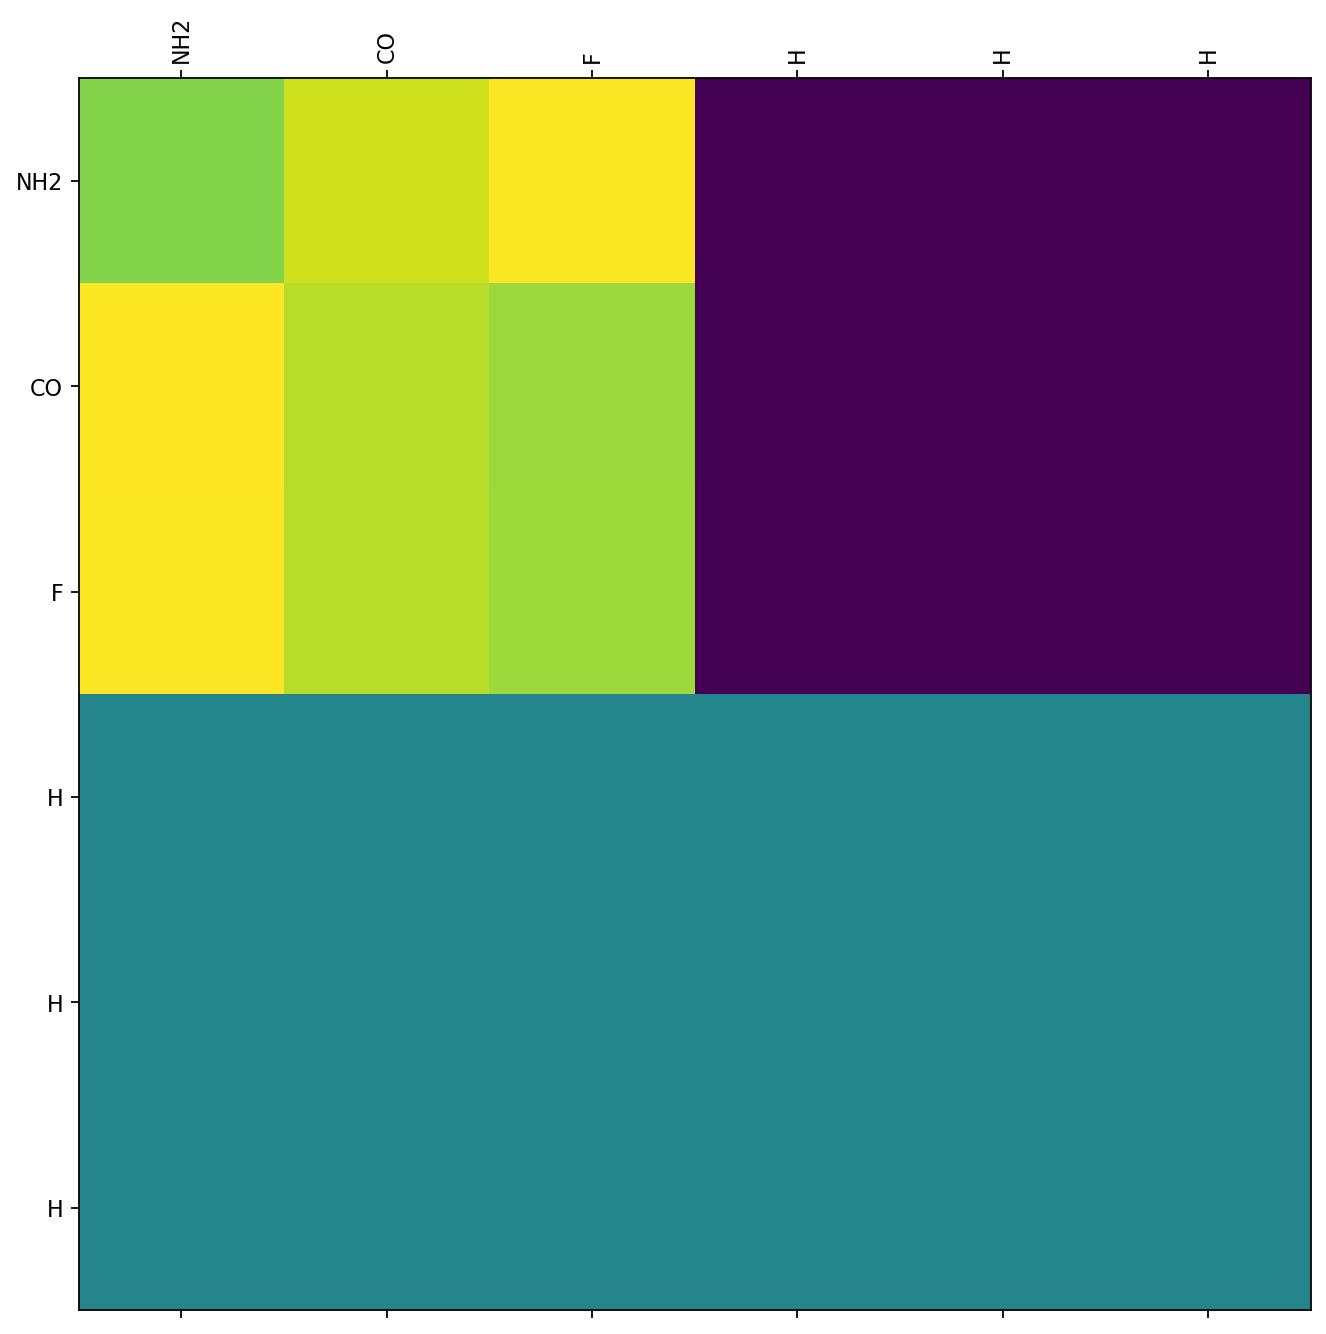

In [123]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention = self_attention_enc_heads[head]
attention.shape
processing.plot_attention_head(attention, compound)

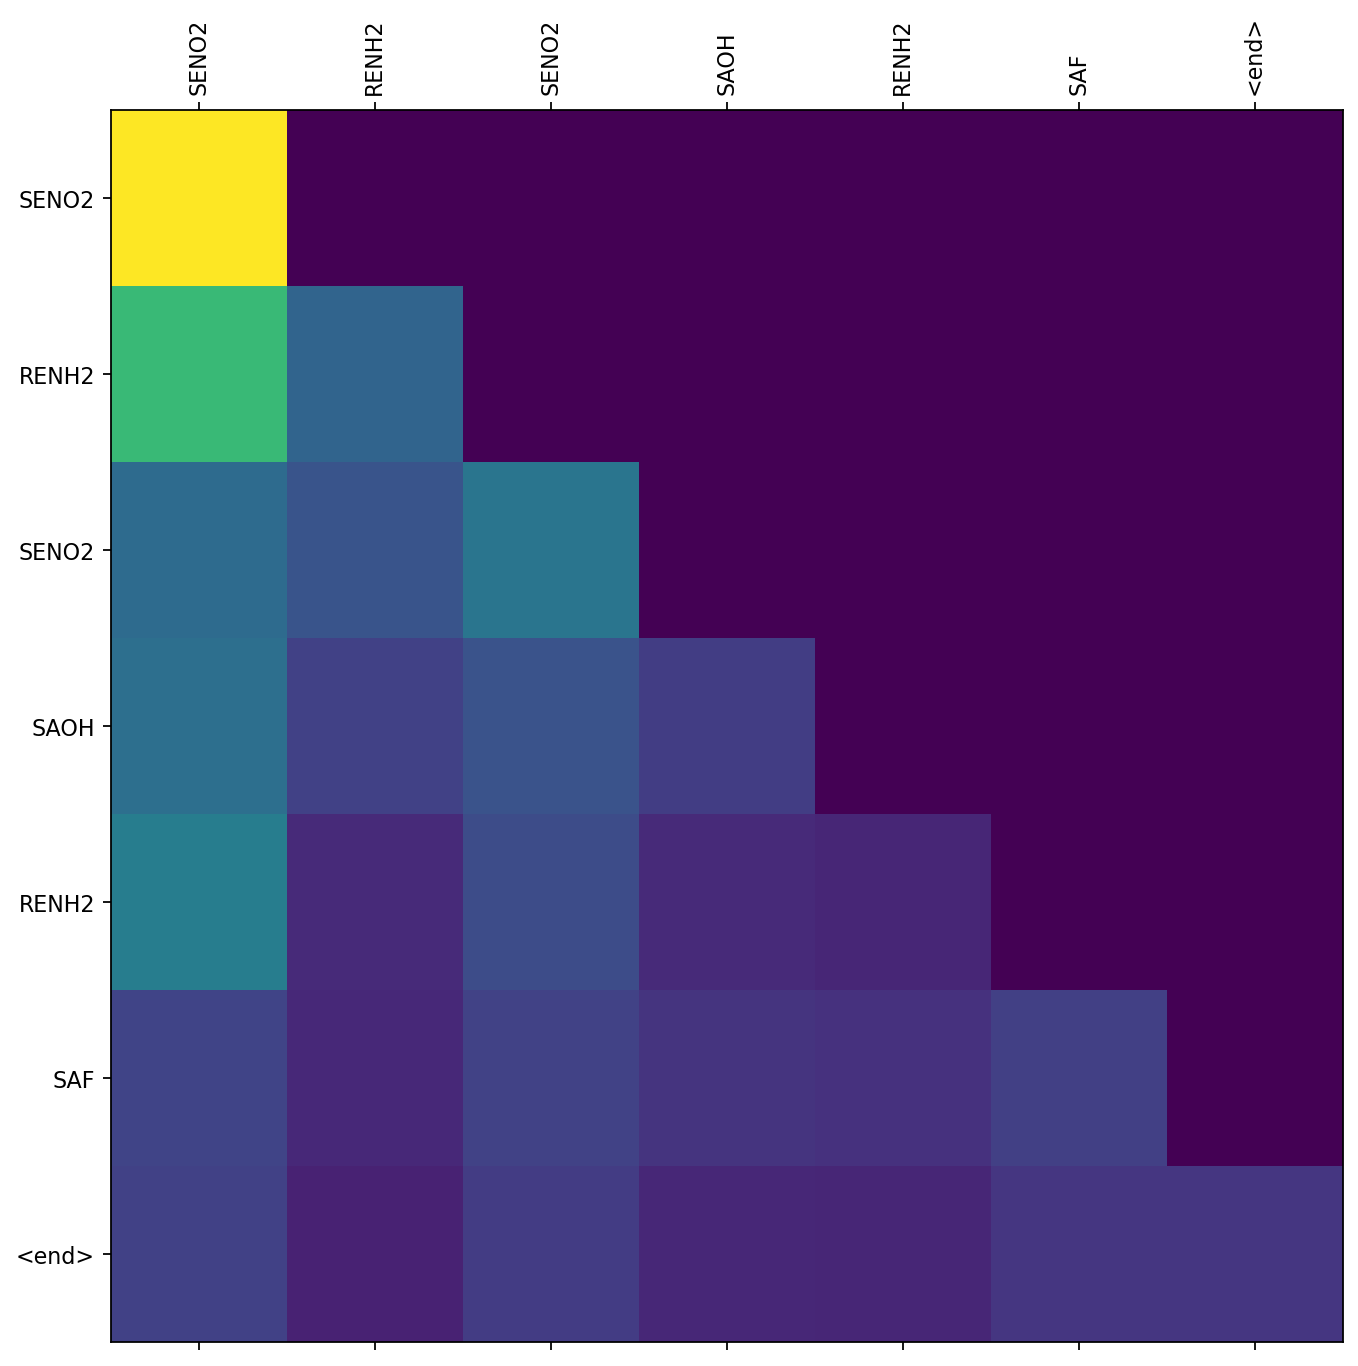

In [124]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention = self_attention_dec_heads[head]
attention.shape
processing.plot_attention_head(attention, synthesis)